In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.decomposition import PCA
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
train_raw=pd.read_csv('train_LTFS.csv')
train=train_raw.copy(deep=True)
test=pd.read_csv('test_LTFS.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             112392 non-null  int64  
 1   disbursed_amount                     112392 non-null  int64  
 2   asset_cost                           112392 non-null  int64  
 3   ltv                                  112392 non-null  float64
 4   branch_id                            112392 non-null  int64  
 5   supplier_id                          112392 non-null  int64  
 6   manufacturer_id                      112392 non-null  int64  
 7   Current_pincode_ID                   112392 non-null  int64  
 8   Date.of.Birth                        112392 non-null  object 
 9   Employment.Type                      108949 non-null  object 
 10  DisbursalDate                        112392 non-null  object 
 11  State_ID     

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'asset_cost')

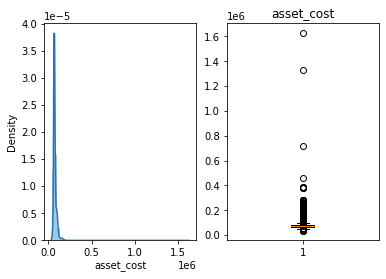

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
sns.distplot(train['asset_cost'])
#plt.hist(df[c])
plt.subplot(1, 2, 2)
plt.boxplot(train['asset_cost'])
plt.title('asset_cost')

In [ ]:
train['Employment.Type'].isnull().value_counts()

False    225493
True       7661
Name: Employment.Type, dtype: int64

In [ ]:
train['DisbursalDate']

0         03-08-18
1         26-09-18
2         01-08-18
3         26-10-18
4         26-09-18
            ...   
233149    26-10-18
233150    23-10-18
233151    24-10-18
233152    29-09-18
233153    27-10-18
Name: DisbursalDate, Length: 233154, dtype: object

In [ ]:
df['AVERAGE.ACCT.AGE']

0          0
1         23
2          0
3          8
4          0
          ..
233149    21
233150     6
233151     0
233152     0
233153     0
Name: AVERAGE.ACCT.AGE, Length: 233154, dtype: int64

In [ ]:
df['DisbursalMonth_8']

0         1
1         0
2         1
3         0
4         0
         ..
233149    0
233150    0
233151    0
233152    0
233153    0
Name: DisbursalMonth_8, Length: 233154, dtype: int64

In [ ]:
# 哪些numeric feature需要logarithm or normalise 还没看，其他preprocess应该都差不多了
# normalise 不会改变skew, log 可以
# 

In [ ]:
def calculate_age(birthDate):
    #birthDate=str(birthDate)
    d,m,y = birthDate.split('-')
    if int(y) < 21: y='20'+y
    else: y= '19'+y
    b = date(int(y),int(m),int(d))
    today=date.today()
    return today.year - b.year - ((today.month, today.day) <(b.month, b.day))

def yrs_mon_to_month(s):
    sp=re.split('yrs|mon',s)
    return int(sp[0])*12 + int(sp[1])

def encode_description(X):
    '''

    '''
    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('No Bureau History Available', 
                                     'Not Scored: Sufficient History Not Available','Not Scored: Not Enough Info available on the customer',
                                     'Not Scored: No Activity seen on the customer (Inactive)', 
                                     'Not Scored: No Updates available in last 36 months', 'Not Scored: Only a Guarantor'),(0, 0, 0, 0, 0, 0))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('L-Very High Risk', 'M-Very High Risk', 
                                     'Not Scored: More than 50 active Accounts found'), (1, 1, 1))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('J-High Risk', 'K-High Risk'), (2, 2))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('H-Medium Risk', 'I-Medium Risk'), (3, 3))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('E-Low Risk', 'F-Low Risk', 'G-Low Risk'), (4, 4, 4))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('A-Very Low Risk', 'B-Very Low Risk',
                                      'C-Very Low Risk', 'D-Very Low Risk'), (5, 5, 5, 5))
    X=X.drop(['PERFORM_CNS.SCORE'], axis=1) # drop PERFORM_CNS.SCORE

def get_balance(df):
    # down sampling negative instances(nondefault), keep all the positive instances
    nondefault=df[df.loan_default==0].sample(n=df.loan_default.value_counts()[1], random_state=0)
    default=df[df.loan_default==1]
    df_balance= default.append(nondefault, ignore_index=True)
    df_balance=df_balance.sample(n=len(df_balance))
    return df_balance

In [ ]:
def preprocess(df):
    # transform birthDate to age
    df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: calculate_age(x))
    df=df.rename(columns={'Date.of.Birth': 'Age'})

    # one hot encoding Employment.Type
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df=pd.DataFrame(enc.fit_transform(df[['Employment.Type']]).toarray())
    df=df.join(enc_df)
    df.columns = df.columns.astype(str) 
    df=df.rename(columns={'0': 'Salaried',
                       '1': 'Self_employed',
                       '2': 'Unknown_employ'})
    df=df.drop('Employment.Type',axis=1)

    # 
    df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda s: yrs_mon_to_month(s))
    df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda s: yrs_mon_to_month(s))

    # transform DisbursalDate to month
    df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'],errors='coerce',dayfirst=True).dt.month
    df=df.rename(columns={'DisbursalDate': 'DisbursalMonth'})

    # encoding DisbursalMonth
    df=pd.get_dummies(df, columns=["DisbursalMonth"], prefix=["DisbursalMonth"])
    df['DisbursalMonth_8'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_9'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_10'] = df['DisbursalMonth_8'].astype(int)

    # encoding description
    encode_description(df)

    # drop some columns with ID (will try encoding later)
    id_col_to_drop=['UniqueID','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID']
    df=df.drop(columns=id_col_to_drop)

    # merge asset_cost and disbursed_amount
    # df['Downpayment']=df['asset_cost']-df['disbursed_amount']
    # df=df.drop(['asset_cost','disbursed_amount'],axis=1)

    # down sample
    #df=get_balance(df)
    return df

In [ ]:
df=preprocess(train)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 38 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   disbursed_amount                     233154 non-null  int64  
 1   asset_cost                           233154 non-null  int64  
 2   ltv                                  233154 non-null  float64
 3   Age                                  233154 non-null  int64  
 4   MobileNo_Avl_Flag                    233154 non-null  int64  
 5   Aadhar_flag                          233154 non-null  int64  
 6   PAN_flag                             233154 non-null  int64  
 7   VoterID_flag                         233154 non-null  int64  
 8   Driving_flag                         233154 non-null  int64  
 9   Passport_flag                        233154 non-null  int64  
 10  PERFORM_CNS.SCORE                    233154 non-null  int64  
 11  PERFORM_CNS.S

In [ ]:
df['Salaried'].value_counts()

0.0    135296
1.0     97858
Name: Salaried, dtype: int64

In [ ]:
df_new2= df[df['Unknown_employ']==1]

In [ ]:
df_new2['loan_default'].value_counts()

0    6017
1    1644
Name: loan_default, dtype: int64

In [ ]:
df['Self_employed'].value_counts()

1.0    127635
0.0    105519
Name: Self_employed, dtype: int64

In [ ]:
df.columns

Index(['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'Salaried', 'Self_employed', 'Unknown_employ',
       'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
       'Downpayment'],
      dtype='object')

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
--------ltv-----
Skewness: -1.075766
Kurtosis: 1.293928
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
--------Age-----
Skewness: 0.607768
Kurtosis: -0.452807
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed 

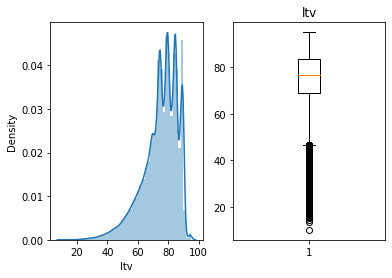

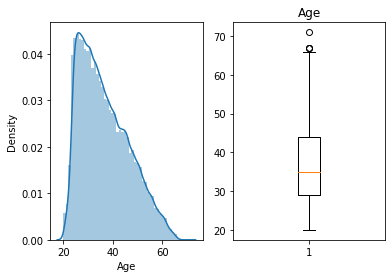

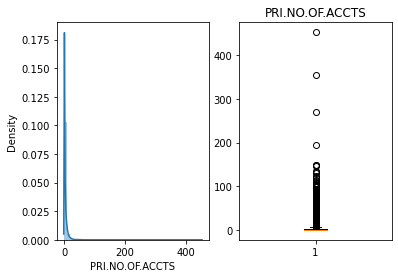

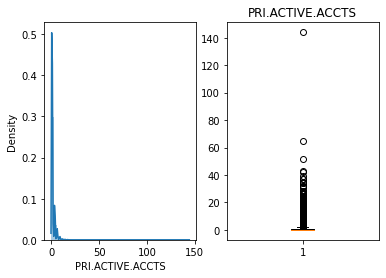

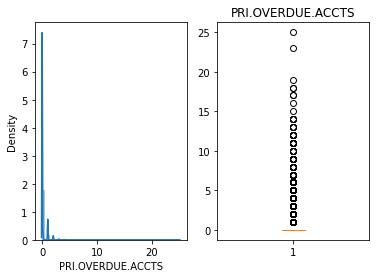

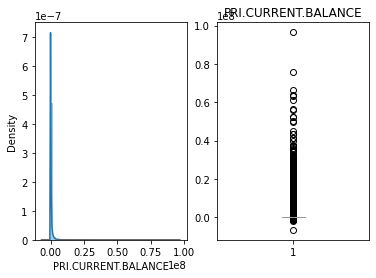

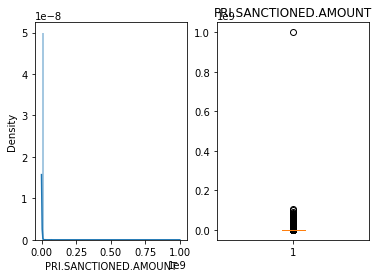

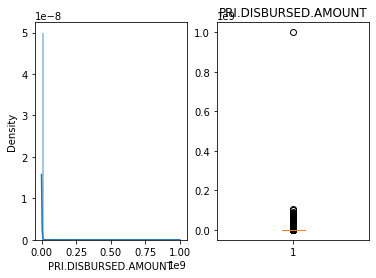

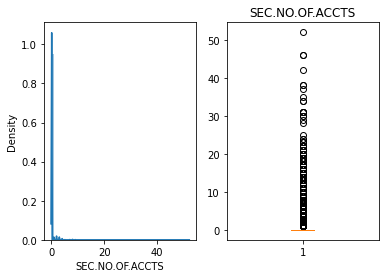

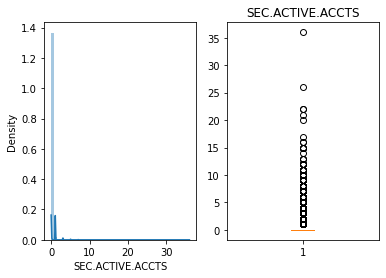

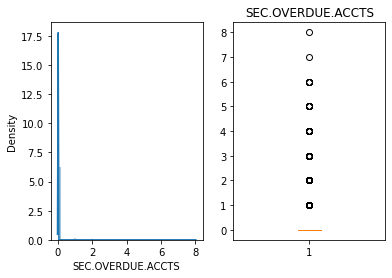

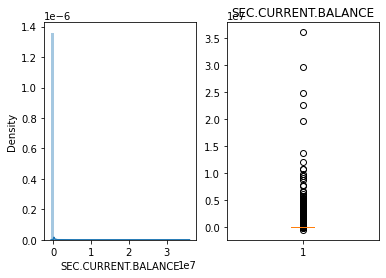

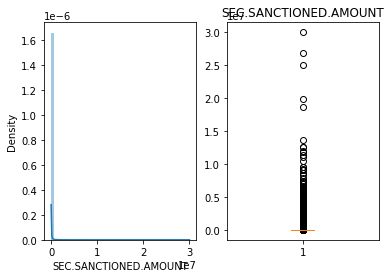

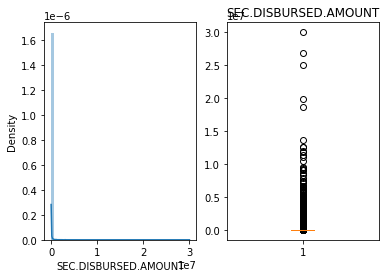

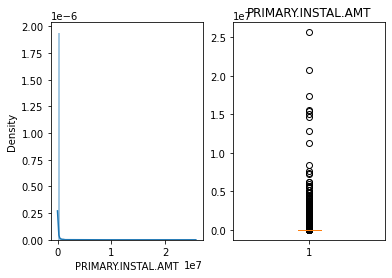

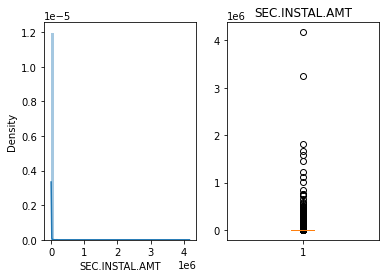

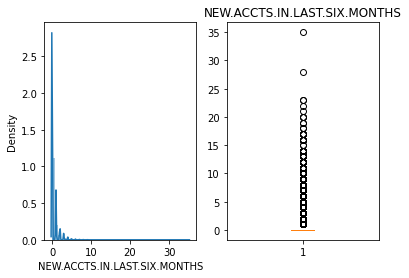

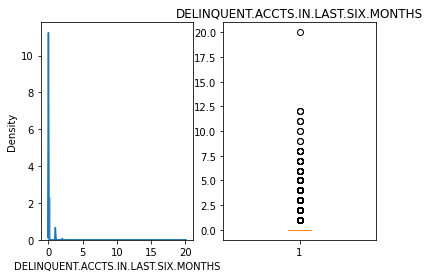

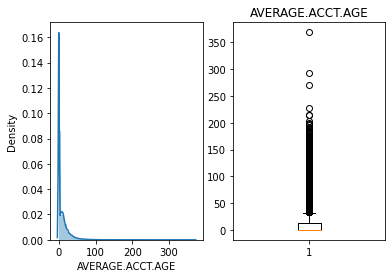

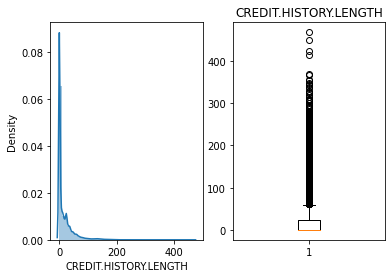

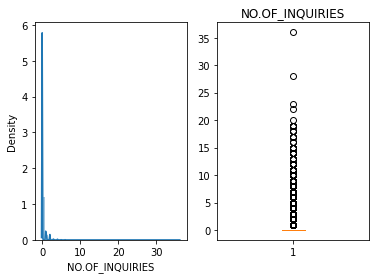

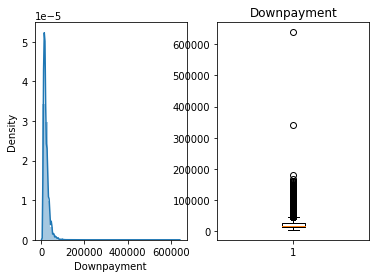

In [ ]:
num_cols= ['ltv', 'Age','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment']
for c in num_cols:

    
       plt.figure()
       plt.subplot(1, 2, 1)
       sns.distplot(df[c])
       #plt.hist(df[c])
       plt.subplot(1, 2, 2)
       plt.boxplot(df[c])
       plt.title(c)
       print('--------{}-----'.format(c))
    #skewness and kurtosis
       print("Skewness: %f" % df[c].skew())
       print("Kurtosis: %f" % df[c].kurt())
    #print(df[c].describe())


In [ ]:
# 移除明显outlier后 取log
print('before shape',df.shape)

drop_max=['PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
for d in drop_max:
    df= df.drop(index=df[df[d]== max(df[d])].index[0])

drop_2max=['Downpayment','SEC.INSTAL.AMT']
for d in drop_2max:
    df= df.drop(index=df[df[d]== max(df[d])].index[0])
    df= df.drop(index=df[df[d]== max(df[d])].index[0])
print('after shape',df.shape)

# to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
#        'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
#        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
#        'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
#        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
#        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment']
# for c in to_log_cols:
#     df[c]=np.log1p(df[c])
# #to_fill_na=['SEC.CURRENT.BALANCE','PRI.CURRENT.BALANCE']
# df=df.apply(lambda x: x.fillna(x.mean()))

before shape (233154, 37)
after shape (233146, 37)


In [ ]:
df_new = 

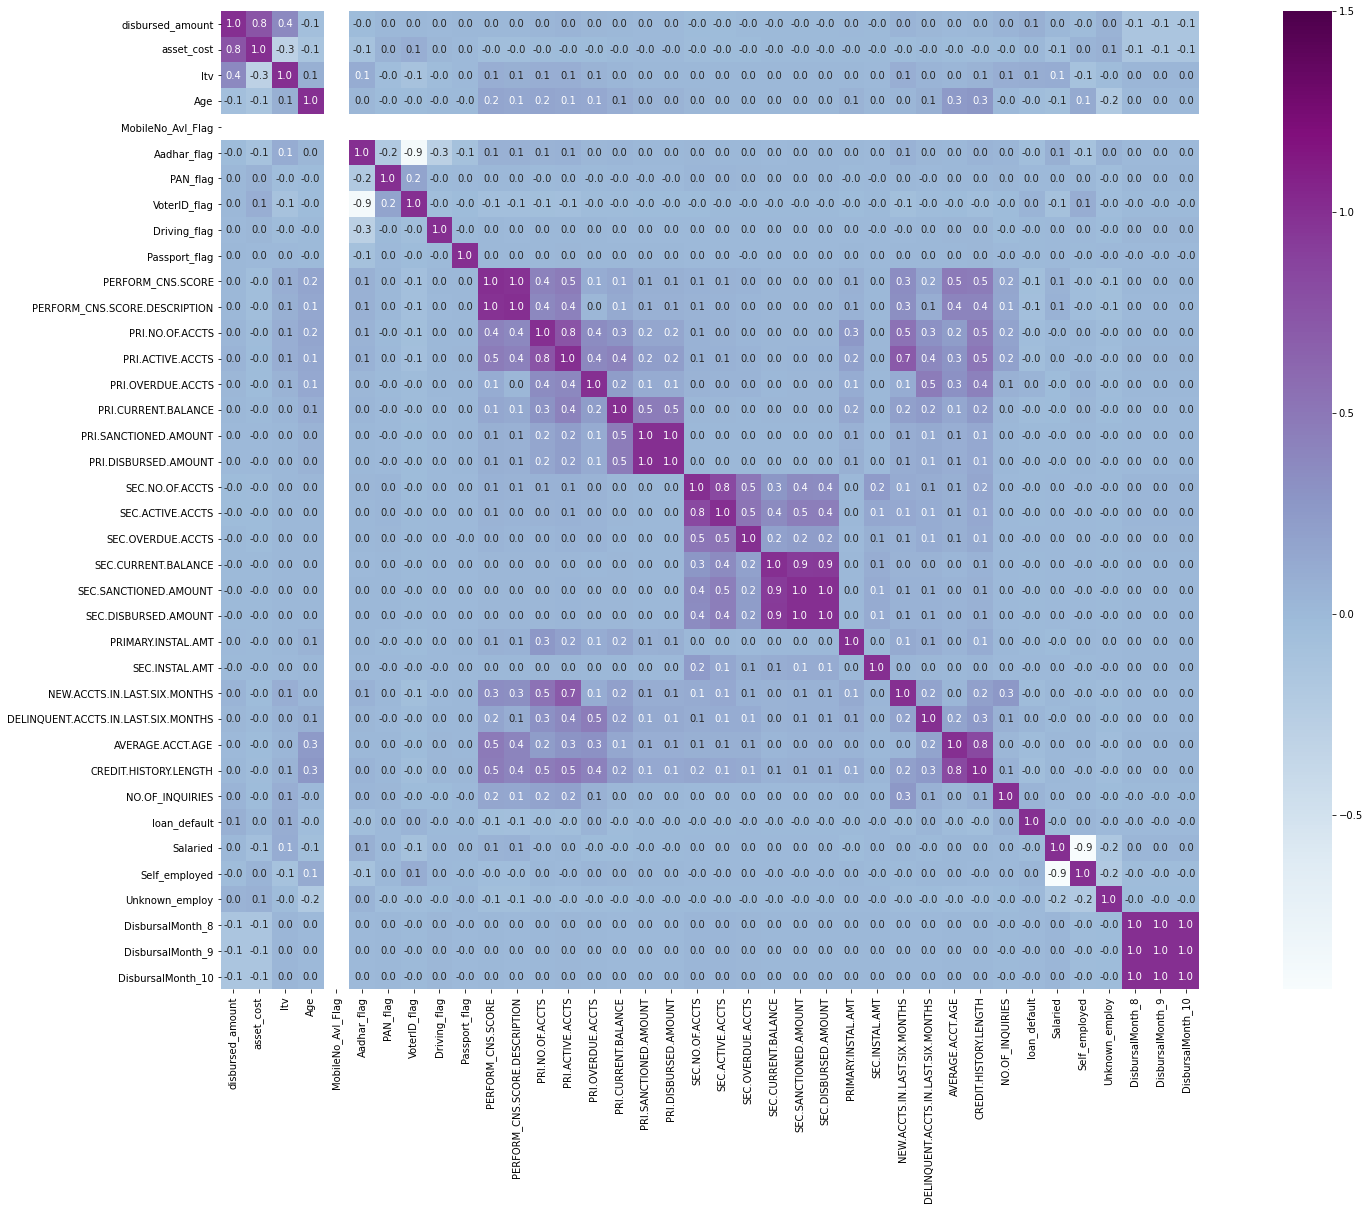

In [ ]:
#correlation matrix
matrix = df.corr() 
f, ax = plt.subplots(figsize=(30, 18)) 
sns.heatmap(matrix, vmax=1.5, square=True,annot=True, fmt=".1f",cmap="BuPu")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 37 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ltv                                  233154 non-null  float64
 1   Age                                  233154 non-null  int64  
 2   MobileNo_Avl_Flag                    233154 non-null  int64  
 3   Aadhar_flag                          233154 non-null  int64  
 4   PAN_flag                             233154 non-null  int64  
 5   VoterID_flag                         233154 non-null  int64  
 6   Driving_flag                         233154 non-null  int64  
 7   Passport_flag                        233154 non-null  int64  
 8   PERFORM_CNS.SCORE                    233154 non-null  int64  
 9   PERFORM_CNS.SCORE.DESCRIPTION        233154 non-null  int64  
 10  PRI.NO.OF.ACCTS                      233154 non-null  int64  
 11  PRI.ACTIVE.AC

In [ ]:
#scatterplot
# sns.set()
# sns.pairplot(df[num_cols], size = 2.5)
# plt.show()

In [ ]:
# in case of positive skewness, log transformations usually works well

In [ ]:
df_test = df.drop(['loan_default'],axis=1)

In [ ]:
df_test.shape[1]

36

In [ ]:
pca = PCA(n_components=36)
principalComponents = pca.fit_transform(df_test)
pc_col=['PC'+str(i+1) for i in range(df_test.shape[1])] # columns
principalDf = pd.DataFrame(data = principalComponents, columns = pc_col)

In [ ]:
principalDf.iloc[:,:16] # X 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,-328729.213522,121943.866903,-10333.588638,-8887.720946,2042.317775,887.795381,-177.523966,-13745.249816,-78.209465,309.000501,5.103891,-0.865496,-0.322326,4.417535,-0.753213,0.147201
1,-254595.521377,104393.259724,-10541.909253,-7592.199769,1770.315207,906.013339,-218.641492,-3155.048335,-64.465161,-310.881856,0.606868,2.844340,9.527123,-3.769508,-0.072525,-0.112746
2,-328729.222286,121943.950439,-10333.693735,-8887.839408,2042.276012,888.086449,-178.454104,-13485.252459,-77.891408,308.449702,5.282183,1.104910,-0.330336,4.598016,-0.716379,0.164445
3,-328729.129912,121943.329031,-10333.739207,-8857.052476,2042.352683,888.668881,-180.256142,-12967.899310,-76.816736,1.917523,2.150795,10.620415,-0.520501,3.263777,0.332314,1.201001
4,-328729.216892,121943.899027,-10333.629059,-8887.766491,2042.301706,887.907327,-177.881683,-13645.250504,-78.087129,308.760035,4.553413,-6.903358,-0.310510,3.641826,-0.795421,0.026994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,308110.814506,-183280.152454,-13320.013471,-14587.131369,-2378.274523,997.943852,-325.015581,20737.733606,-36.656766,-480.819546,-5.325583,5.639264,-0.010442,1.373618,-1.007244,-0.474744
233150,-328724.435188,121910.980123,-10333.373155,-7331.891898,2049.013239,910.132499,-247.208269,5380.508734,-53.588636,-556.542150,32.830823,3.621420,0.533144,3.946630,-3.173317,1.203066
233151,-328730.221544,121953.475236,-10345.677178,-8901.346247,2037.513921,921.274724,-284.510261,16160.463095,-41.625315,244.643223,3.990642,-11.049527,-0.314610,-13.147460,-0.067642,-0.039482
233152,-328730.265331,121953.892597,-10346.202262,-8901.938121,2037.305277,922.728947,-289.157405,17459.450277,-40.036259,241.920629,5.527083,5.834299,-0.343088,-12.316418,0.196264,0.091684


In [ ]:
exp_variance_ratio=pca.explained_variance_ratio_
exp_variance=pca.explained_variance_
exp_variance_cumsum=np.cumsum(exp_variance_ratio)

In [ ]:
exp_variance

array([1.14930459e+13, 6.81777959e+11, 9.29870844e+10, 2.23643849e+10,
       6.96032560e+09, 2.82747551e+09, 2.38623536e+08, 1.57133530e+08,
       1.17415113e+07, 1.11003922e+05, 7.26776716e+02, 8.71567850e+01,
       5.98137601e+01, 3.74169644e+01, 1.52696918e+01, 1.50622828e+00,
       6.16644936e-01, 4.87621797e-01, 4.62298514e-01, 3.88038304e-01,
       3.26796098e-01, 2.39822639e-01, 2.32700937e-01, 9.52812369e-02,
       8.48385446e-02, 6.60629495e-02, 4.54461304e-02, 3.23894712e-02,
       2.37236825e-02, 8.45986370e-03, 6.77225237e-03, 1.90652567e-03,
       8.41760330e-20, 8.41760330e-20, 8.41760330e-20, 8.41760330e-20])

Text(0, 0.5, 'Explained variance')

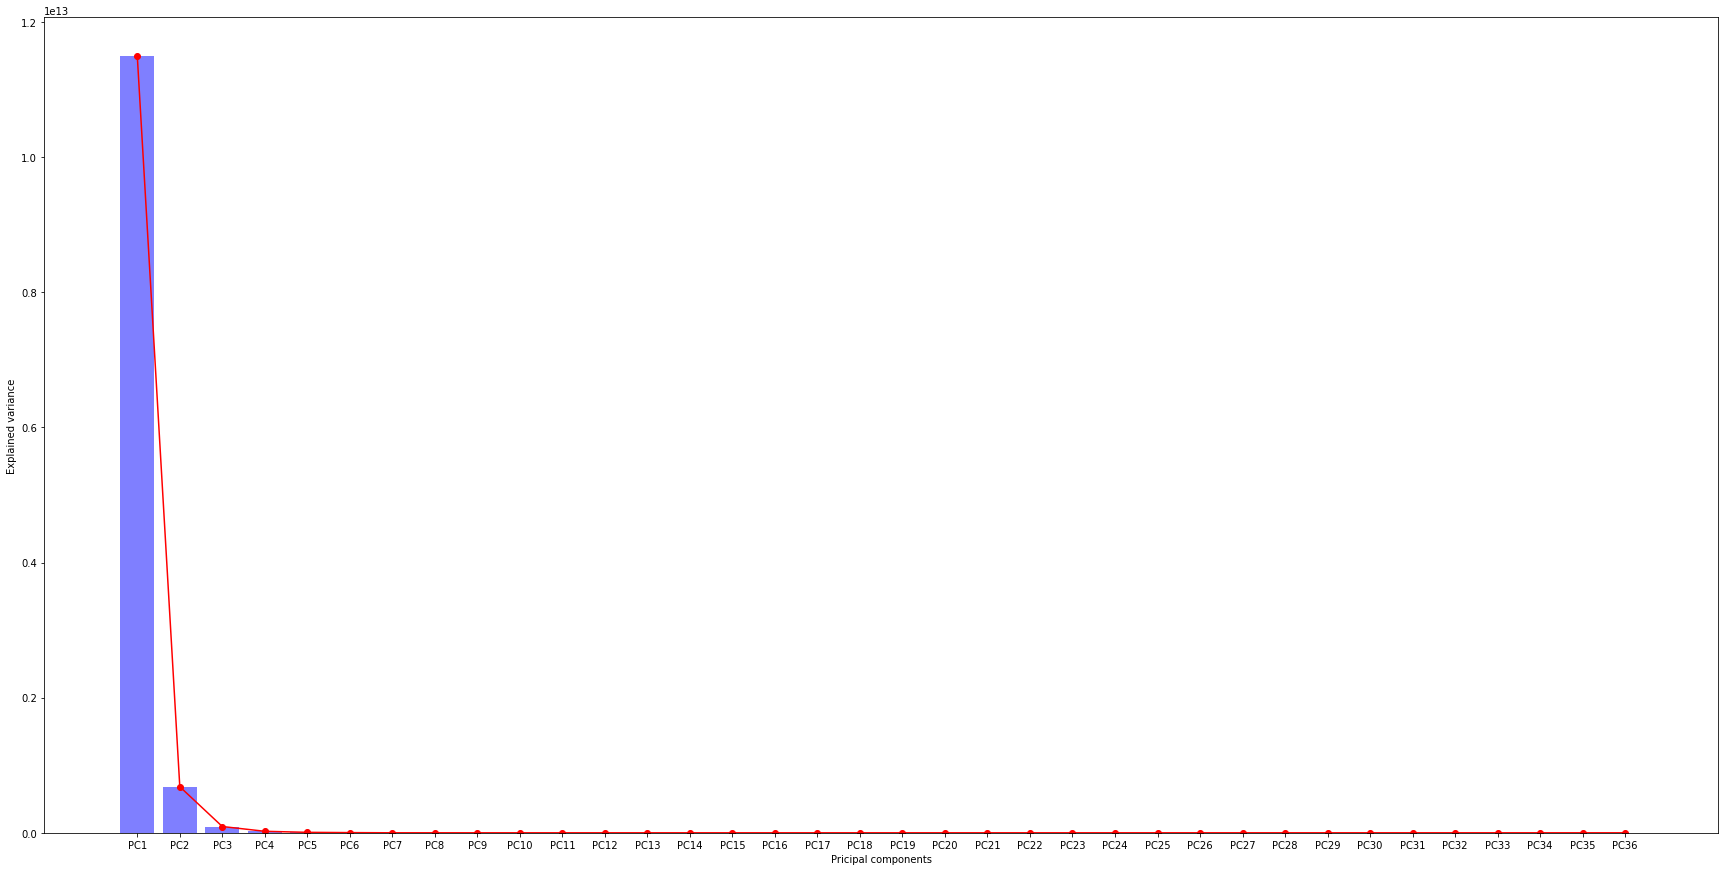

In [ ]:
xx=np.arange(1,37)
plt.figure(figsize=(30,15))
plt.plot(xx,exp_variance,'-o',color='red')
plt.bar(xx,exp_variance,color='blue',alpha=0.5)
plt.xticks(xx,pc_col)
#plt.grid()
plt.xlabel('Pricipal components')
plt.ylabel('Explained variance')
#plt.savefig('PCA_bar.jpg',dpi=100)

In [ ]:
df_test.columns

Index(['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'Salaried', 'Self_employed', 'Unknown_employ', 'DisbursalMonth_8',
       'DisbursalMonth_9', 'DisbursalMonth_10', 'Downpayment'],
      dtype='object')

Text(0.5, 0, 'Assets')

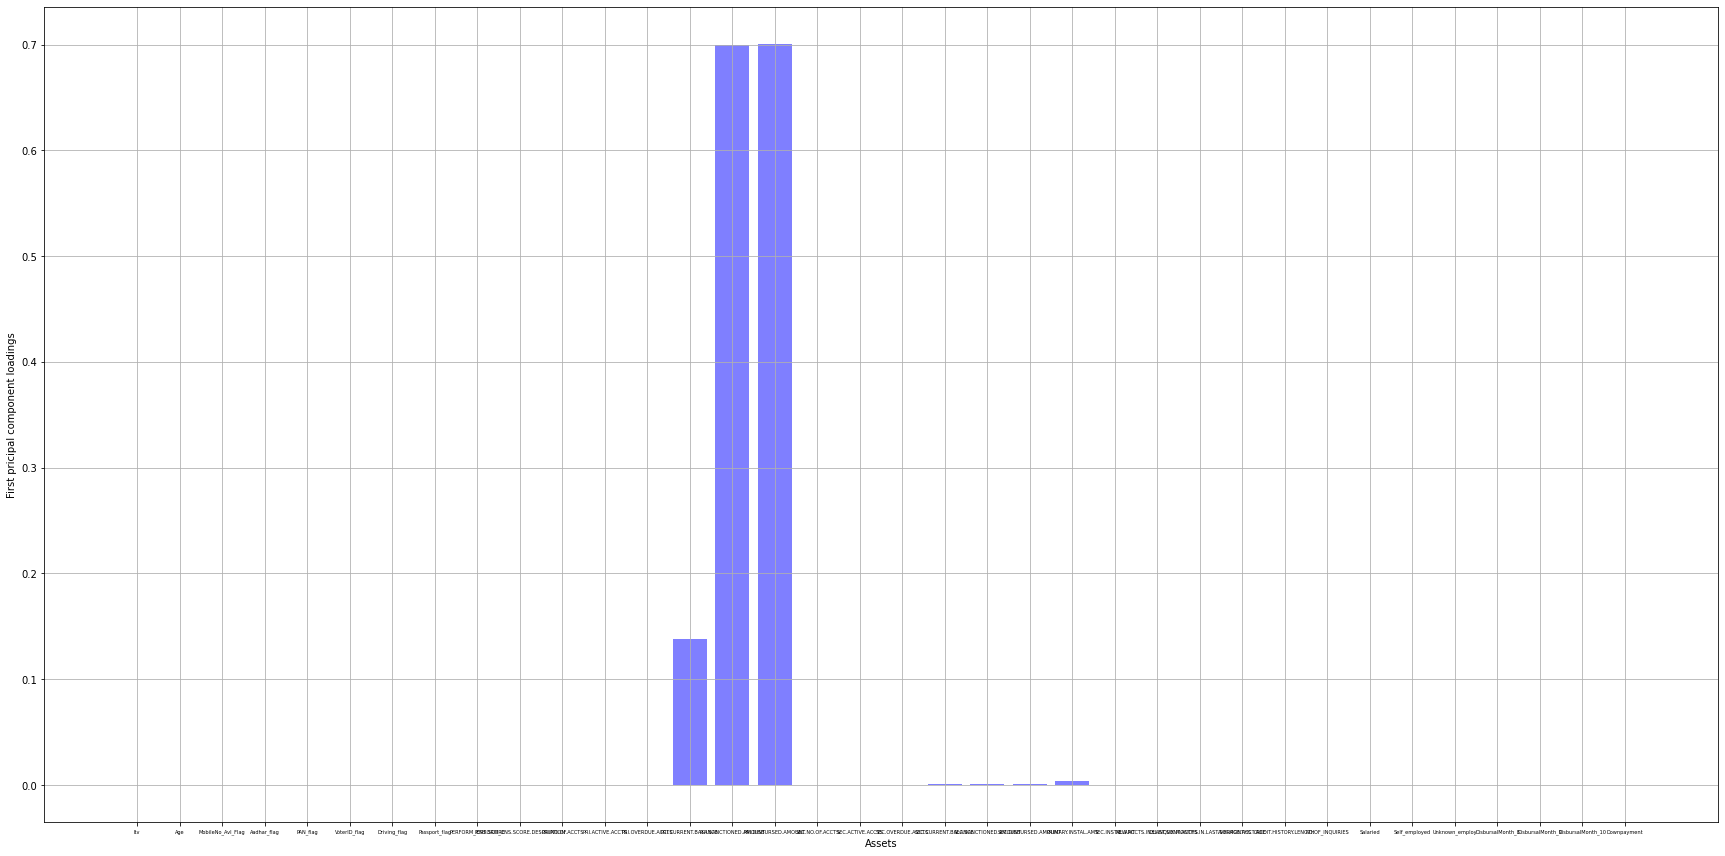

In [ ]:
feat_cols = ['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 
       'Salaried', 'Self_employed', 'Unknown_employ',
       'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
       'Downpayment']
xx=np.arange(1,37)
fig = plt.figure(figsize=(30,15))
plt.bar(xx,pca.components_[0],color='blue',alpha=0.5)
plt.xticks(xx, feat_cols,fontsize=5)
plt.grid()
plt.ylabel('First pricipal component loadings')
plt.xlabel('Assets')

Text(0.5, 0, 'Assets')

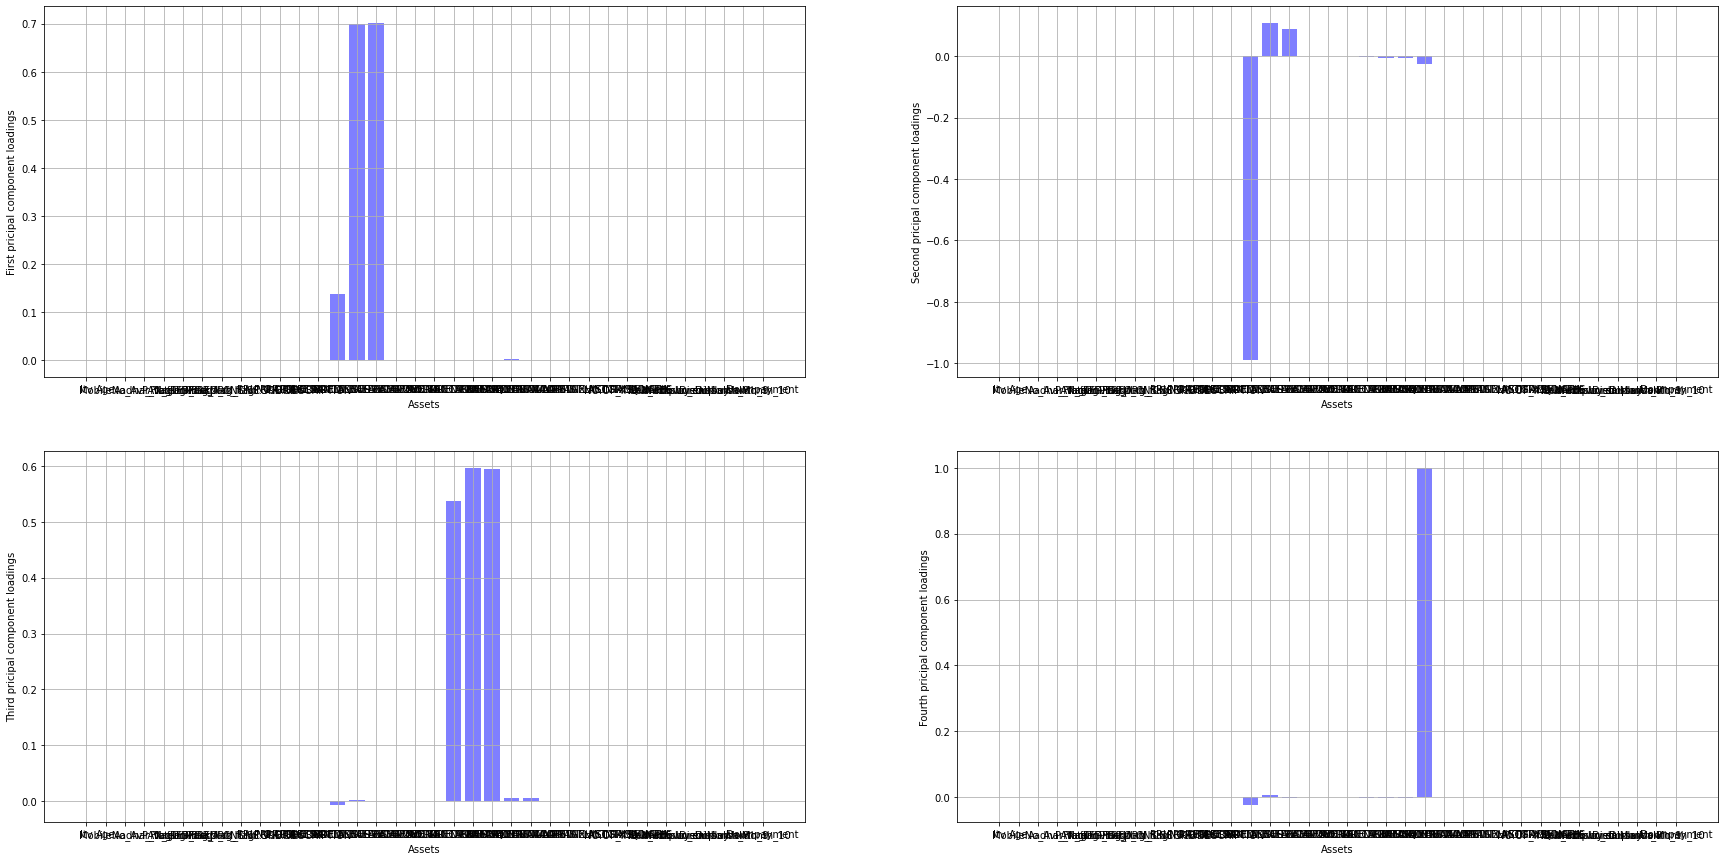

In [ ]:
feat_cols = ['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'Salaried', 'Self_employed', 'Unknown_employ',
       'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
       'Downpayment']
xx=np.arange(1,37)
fig = plt.figure(figsize=(30,15))
plt.subplot(2, 2, 1)
plt.bar(xx,pca.components_[0],color='blue',alpha=0.5)
plt.xticks(xx, feat_cols)
plt.grid()
plt.ylabel('First pricipal component loadings')
plt.xlabel('Assets')

plt.subplot(2, 2, 2)
plt.bar(xx,pca.components_[1],color='blue',alpha=0.5)
plt.xticks(xx, feat_cols)
plt.grid()
plt.ylabel('Second pricipal component loadings')
plt.xlabel('Assets')

plt.subplot(2, 2, 3)
plt.bar(xx,pca.components_[2],color='blue',alpha=0.5)
plt.xticks(xx, feat_cols)
plt.grid()
plt.ylabel('Third pricipal component loadings')
plt.xlabel('Assets')

plt.subplot(2, 2, 4)
plt.bar(xx,pca.components_[3],color='blue',alpha=0.5)
plt.xticks(xx, feat_cols)
plt.grid()
plt.ylabel('Fourth pricipal component loadings')
plt.xlabel('Assets')

#plt.savefig('PCA_loadings.jpg',dpi=100)

In [ ]:
pca_1 = principalDf.iloc[:,:16] # X 

In [ ]:
X = principalDf.iloc[:,:16]
y = df.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
lr=LogisticRegression(class_weight='balanced').fit(X_train,y_train)
y_vali_pred=lr.predict(X_vali)
confusion = metrics.confusion_matrix(y_vali, y_vali_pred)
print('----confusion matrix----')
print(confusion)
# print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, y_vali_pred))

----confusion matrix----
[[21280 33499]
 [ 4712 10456]]
              precision    recall  f1-score   support

           0       0.82      0.39      0.53     54779
           1       0.24      0.69      0.35     15168

    accuracy                           0.45     69947
   macro avg       0.53      0.54      0.44     69947
weighted avg       0.69      0.45      0.49     69947



In [ ]:
print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))

Accuracy_Score: 0.453714955609247


In [ ]:
lr.coef_

array([[-1.72792150e-08,  1.23743536e-07, -2.72500220e-08,
        -1.58422660e-07,  8.88658360e-07,  1.13400343e-07,
        -2.33022442e-07, -1.25154586e-05, -2.97447740e-07,
         4.89154798e-07,  4.32070052e-09,  7.76639860e-09,
         3.88672731e-09,  1.48733764e-08,  6.08528399e-10,
         1.19167042e-11]])

In [ ]:
X = df_test
y = df.loan_default
knn = KNeighborsClassifier(n_neighbors=4)
sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y)

NameError: name 'SFS' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85463a1c-f246-4a97-953d-d1ccc73b61e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>